In [ ]:
import pandas as pd
from datasets import load_dataset
import os

Our data begins as a bunch of PGN transcripts. However, to work in tensors we need all transcripts to be the same length. So, this file takes our PGNs and performs some filtering.

This notebook has a very similar counterpart, `utils\chess_gpt_eval_data_filtering.ipynb`. The lichess and chess_gpt_eval datasets have a different structure and different column names. For most peoples' needs, the lichess dataset alone should suffice, so I made two separate notebooks to keep this one simple.

The output of this file is 4 different csv's:

`lichess_100mb.csv`" 100 MB of lichess PGN games, with every game also containing player Elo information.

`lichess_100mb_filtered.csv`: We perform some filtering for game length, add player Elo bucket, and do some manipulation of the PGN string.

`lichess_train.csv` and `lichess_test.csv` a 50 / 50 train / test split of `lichess_100mb_filtered.csv`, used for training and testing linear probes.

In [ ]:
DATA_DIR = "data/"
prefix = "lichess_"


input_file = f'{DATA_DIR}{prefix}100mb.csv'
output_file = input_file.replace(".csv", "_filtered.csv")

First, we download the dataset if not present.

In [ ]:
if not os.path.exists(input_file):
    dataset_path = "adamkarvonen/chess_games"
    file_path = f"{prefix}100mb.zip"
    # No idea why streaming=True is required to avoid an error here. Huggingface ¯\_(ツ)_/¯
    dataset = load_dataset(dataset_path, data_files=file_path,streaming=True)
    df = pd.DataFrame(dataset['train'])
    df.to_csv(input_file, index=False)

Our LLMs need a delimiter token ";" at the beginning of every PGN string or it won't work as well.

In [ ]:
df = pd.read_csv(input_file)

def format_transcript(game: str) -> str:
    new_game = ';' + game
    return new_game

df['transcript'] = df['transcript'].apply(format_transcript)

for game in df.head()['transcript']:
    print(game)
    print()

Filter all games to be len 365. This means we discard anything under that length. I chose 365 because that's the 50% of df.describe(). I also count the number of moves (with x.split()) and discard anything below the 25th percentile. This makes it easier if I want to do any move based indexing.

In [ ]:
len_df = df['transcript'].apply(lambda x: len(x))
print(len_df.describe())

game_length_in_chars = 365

# Data setup. All games must have same length. 50% are >= 690 moves. I will discard all games less than 680, and truncate the rest to 680.
filtered_df = df[df['transcript'].apply(lambda x: len(x) >= game_length_in_chars)].copy()
filtered_df.loc[:, 'transcript'] = filtered_df['transcript'].apply(lambda x: x[:game_length_in_chars])

len_df = filtered_df['transcript'].apply(lambda x: len(x))
print(len_df.describe())

move_count_df = filtered_df['transcript'].apply(lambda x: len(x.split()))
move_count = move_count_df.describe()
print("move count", move_count_df.describe())
quarter_percentile = move_count['25%']
print("quarter percentile", quarter_percentile)

# Now I need to filter out games that are too short. I will discard all games less than 25th percentile  moves.
filtered_df = filtered_df[filtered_df['transcript'].apply(lambda x: len(x.split()) >= quarter_percentile)]
print(filtered_df.describe())
print(filtered_df.head())

filtered_df.to_csv(output_file, index=False)

move_count_df = filtered_df['transcript'].apply(lambda x: len(x.split()))
print(move_count_df.describe())

In [ ]:
print(len(filtered_df))
print(filtered_df['WhiteElo'].describe())

For the classification task, I wanted some Elo bins for the probe to classify. This somewhat arbitrarily creates 6 different Elo bins.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Function to create binned columns and bin index columns
def create_binned_columns(df, column_name):

    # Ensure column is numeric and handle NaN values. Here, we choose to drop them, but you might fill them instead.
    if df[column_name].dtype.kind not in 'biufc' or pd.isnull(df[column_name]).any():
        df = df.dropna(subset=[column_name])
        df[column_name] = pd.to_numeric(df[column_name], errors='coerce')

    binned_column_name = f'{column_name}Binned'
    bin_index_column_name = f'{column_name}BinIndex'

    # Create quantile-based bins
    num_bins = 6
    # Create quantile-based bins with range labels, dropping duplicates if necessary
    df[binned_column_name], bins = pd.qcut(df[column_name], q=num_bins, retbins=True, duplicates='drop')

    # Convert bin labels to strings and assign to the column
    df[binned_column_name] = df[binned_column_name].apply(lambda x: f'({x.left}, {x.right}]')

    # Create bin index column
    df[bin_index_column_name] = pd.qcut(df[column_name], q=num_bins, labels=False, duplicates='drop')

# Apply the function to both WhiteElo and BlackElo
create_binned_columns(filtered_df, 'WhiteElo')
create_binned_columns(filtered_df, 'BlackElo')

filtered_df.to_csv(output_file, index=False)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Histogram for WhiteElo
axes[0].hist(filtered_df['WhiteElo'], bins=30, color='blue', alpha=0.7)
axes[0].set_title('WhiteElo Distribution')
axes[0].set_xlabel('WhiteElo')
axes[0].set_ylabel('Frequency')

# Bar chart for WhiteEloBinned
bin_counts = filtered_df['WhiteEloBinned'].value_counts()
axes[1].bar(bin_counts.index.astype(str), bin_counts.values, color='green', alpha=0.7)
axes[1].set_title('WhiteElo Binned Distribution')
axes[1].set_xlabel('WhiteElo Bins')
axes[1].set_ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [ ]:
print(filtered_df['WhiteEloBinned'].value_counts())

In [ ]:
print(filtered_df.head())

In [ ]:
# shuffle all rows of the dataset

df = pd.read_csv(output_file)
df = df.sample(frac=1, random_state=200).reset_index(drop=True)
df.to_csv(output_file, index=False)

In [ ]:
import pandas as pd
df = pd.read_csv(output_file)

print(len(df))

# Split df into a train and test split
train = df.sample(frac=0.5, random_state=200)
test = df.drop(train.index)

print(len(train))
print(len(test))

# Save the train and test splits to csv
train.to_csv(f'{DATA_DIR}{prefix}train.csv', index=False)
test.to_csv(f'{DATA_DIR}{prefix}test.csv', index=False)

In [6]:
import chess
import chess.pgn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Constants
MAX_MOVES = 15  # Limit to first 15 moves
BOARD_SIZE = 8
NUM_PIECE_TYPES = 12  # 6 piece types for each color

# Function to convert board to tensor
def board_to_tensor(board):
    tensor = torch.zeros(NUM_PIECE_TYPES, BOARD_SIZE, BOARD_SIZE)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            color = int(piece.color)
            piece_type = piece.piece_type - 1
            rank, file = divmod(square, 8)
            tensor[piece_type + 6 * color][rank][file] = 1
    return tensor

# Custom dataset
class StaffordGambitDataset(Dataset):
    def __init__(self, games):
        self.positions = []
        self.moves = []

        for game in games:
            board = game.board()
            for i, move in enumerate(game.mainline_moves()):
                if i >= MAX_MOVES * 2:  # Both players' moves
                    break
                if board.turn == chess.BLACK:  # We're only interested in Black's moves
                    self.positions.append(board_to_tensor(board))
                    self.moves.append(move.from_square * 64 + move.to_square)
                board.push(move)

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        return self.positions[idx], self.moves[idx]

# Define the model
class StaffordGambitModel(nn.Module):
    def __init__(self):
        super(StaffordGambitModel, self).__init__()
        self.conv1 = nn.Conv2d(NUM_PIECE_TYPES, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * BOARD_SIZE * BOARD_SIZE, 1024)
        self.fc2 = nn.Linear(1024, 64 * 64)  # Output for all possible moves

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(-1, 256 * BOARD_SIZE * BOARD_SIZE)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# Main execution
def main():
    # Load your PGN file with Stafford Gambit games
    games = []
    with open('stafford.txt') as pgn:
        while True:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break
            games.append(game)

    # Create dataset and dataloader
    dataset = StaffordGambitDataset(games)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Initialize model, optimizer, and loss function
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = StaffordGambitModel().to(device)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        train(model, train_loader, optimizer, criterion, device)
        print(f"Epoch {epoch+1}/{num_epochs} completed")

    # Save the model
    torch.save(model.state_dict(), 'stafford_gambit_model.pth')

if __name__ == "__main__":
    main()


Epoch 1/10 completed
Epoch 2/10 completed
Epoch 3/10 completed
Epoch 4/10 completed
Epoch 5/10 completed
Epoch 6/10 completed
Epoch 7/10 completed
Epoch 8/10 completed
Epoch 9/10 completed
Epoch 10/10 completed


In [7]:
def load_model(model_path, device):
    model = StaffordGambitModel().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model


In [8]:
# Custom validation dataset
class StaffordGambitValidationDataset(Dataset):
    def __init__(self, games):
        self.positions = []
        self.moves = []

        for game in games:
            board = game.board()
            for i, move in enumerate(game.mainline_moves()):
                if i >= MAX_MOVES * 2:  # Both players' moves
                    break
                if board.turn == chess.BLACK:  # We're only interested in Black's moves
                    self.positions.append(board_to_tensor(board))
                    self.moves.append(move.from_square * 64 + move.to_square)
                board.push(move)

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        return self.positions[idx], self.moves[idx]

# Load validation games
def load_validation_games(file_path):
    games = []
    with open(file_path) as pgn:
        while True:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break
            games.append(game)
    return games


In [10]:
def evaluate_model(model, validation_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    validation_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            validation_loss += loss.item() * data.size(0)  # Sum the batch losses
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

    validation_loss /= total  # Average loss
    accuracy = correct / total
    return validation_loss, accuracy

# Main validation function
def main_validation():
    # Load validation games
    validation_games = load_validation_games('stafford.txt')

    # Create validation dataset and dataloader
    validation_dataset = StaffordGambitValidationDataset(validation_games)
    validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

    # Initialize model, criterion
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_model('stafford_gambit_model.pth', device)
    criterion = nn.CrossEntropyLoss()

    # Evaluate model
    validation_loss, validation_accuracy = evaluate_model(model, validation_loader, criterion, device)
    print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

if __name__ == "__main__":
    main_validation()


Validation Loss: 2.0788, Validation Accuracy: 0.5166


In [11]:
import chess
import chess.pgn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

# Constants
MAX_MOVES = 15
BOARD_SIZE = 8
NUM_PIECE_TYPES = 12
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

# Function to convert board to tensor
def board_to_tensor(board):
    tensor = torch.zeros(NUM_PIECE_TYPES, BOARD_SIZE, BOARD_SIZE)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            color = int(piece.color)
            piece_type = piece.piece_type - 1
            rank, file = divmod(square, 8)
            tensor[piece_type + 6 * color][rank][file] = 1
    return tensor

# Custom dataset
class StaffordGambitDataset(Dataset):
    def __init__(self, games):
        self.positions = []
        self.moves = []

        for game in games:
            board = game.board()
            for i, move in enumerate(game.mainline_moves()):
                if i >= MAX_MOVES * 2:
                    break
                if board.turn == chess.BLACK:
                    self.positions.append(board_to_tensor(board))
                    self.moves.append(move.from_square * 64 + move.to_square)
                board.push(move)

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        return self.positions[idx], self.moves[idx]

# Define the model
class StaffordGambitModel(nn.Module):
    def __init__(self):
        super(StaffordGambitModel, self).__init__()
        self.conv1 = nn.Conv2d(NUM_PIECE_TYPES, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * BOARD_SIZE * BOARD_SIZE, 1024)
        self.fc2 = nn.Linear(1024, 64 * 64)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(-1, 256 * BOARD_SIZE * BOARD_SIZE)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += criterion(output, target).item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
    return loss / total, correct / total

# Main function
def main():
    # Load your PGN file with Stafford Gambit games
    games = []
    with open('stafford.txt') as pgn:
        while True:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break
            games.append(game)

    # Split data into training and validation sets
    train_games, val_games = train_test_split(games, test_size=0.2, random_state=42)

    # Create datasets and dataloaders
    train_dataset = StaffordGambitDataset(train_games)
    val_dataset = StaffordGambitDataset(val_games)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, and loss function
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = StaffordGambitModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(EPOCHS):
        train(model, train_loader, optimizer, criterion, device)
        train_loss, train_accuracy = evaluate(model, train_loader, criterion, device)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"                 - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Save the model
    torch.save(model.state_dict(), 'stafford_gambit_model.pth')

if __name__ == "__main__":
    main()


Epoch 1/20 - Train Loss: 5.6364, Train Accuracy: 0.0984
                 - Val Loss: 5.3306, Val Accuracy: 0.1379
Epoch 2/20 - Train Loss: 4.3830, Train Accuracy: 0.0984
                 - Val Loss: 4.6930, Val Accuracy: 0.1379
Epoch 3/20 - Train Loss: 3.8586, Train Accuracy: 0.0984
                 - Val Loss: 4.7174, Val Accuracy: 0.1379
Epoch 4/20 - Train Loss: 3.5258, Train Accuracy: 0.1066
                 - Val Loss: 4.8619, Val Accuracy: 0.1379
Epoch 5/20 - Train Loss: 3.3068, Train Accuracy: 0.0984
                 - Val Loss: 4.4309, Val Accuracy: 0.1379
Epoch 6/20 - Train Loss: 3.1950, Train Accuracy: 0.0984
                 - Val Loss: 4.1250, Val Accuracy: 0.1379
Epoch 7/20 - Train Loss: 3.1110, Train Accuracy: 0.1066
                 - Val Loss: 3.9788, Val Accuracy: 0.1379
Epoch 8/20 - Train Loss: 3.0633, Train Accuracy: 0.1066
                 - Val Loss: 3.9084, Val Accuracy: 0.1379
Epoch 9/20 - Train Loss: 2.9973, Train Accuracy: 0.1066
                 - Val Loss: 3.8

In [2]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.8 MB/s eta 0:00:00


In [8]:
# Cell 1: Imports and Constants

import chess
import chess.pgn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

# Constants
MAX_MOVES = 15
BOARD_SIZE = 8
NUM_PIECE_TYPES = 12
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001


In [9]:
# Cell 2: Function to Convert Board to Tensor

def board_to_tensor(board):
    tensor = torch.zeros(NUM_PIECE_TYPES, BOARD_SIZE, BOARD_SIZE)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            color = int(piece.color)
            piece_type = piece.piece_type - 1
            rank, file = divmod(square, 8)
            tensor[piece_type + 6 * color][rank][file] = 1
    return tensor


In [10]:
# Cell 3: Custom Dataset

class StaffordGambitDataset(Dataset):
    def __init__(self, games):
        self.positions = []
        self.moves = []

        for game in games:
            board = game.board()
            for i, move in enumerate(game.mainline_moves()):
                if i >= MAX_MOVES * 2:
                    break
                if board.turn == chess.BLACK:
                    self.positions.append(board_to_tensor(board))
                    self.moves.append(move.from_square * 64 + move.to_square)
                board.push(move)

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        return self.positions[idx], self.moves[idx]


In [11]:
# Cell 3: Custom Dataset

class StaffordGambitDataset(Dataset):
    def __init__(self, games):
        self.positions = []
        self.moves = []

        for game in games:
            board = game.board()
            for i, move in enumerate(game.mainline_moves()):
                if i >= MAX_MOVES * 2:
                    break
                if board.turn == chess.BLACK:
                    self.positions.append(board_to_tensor(board))
                    self.moves.append(move.from_square * 64 + move.to_square)
                board.push(move)

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        return self.positions[idx], self.moves[idx]


In [12]:
# Cell 4: Define the Model

class StaffordGambitModel(nn.Module):
    def __init__(self):
        super(StaffordGambitModel, self).__init__()
        self.conv1 = nn.Conv2d(NUM_PIECE_TYPES, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * BOARD_SIZE * BOARD_SIZE, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 64 * 64)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 256 * BOARD_SIZE * BOARD_SIZE)
        x = torch.relu(self.dropout(self.fc1(x)))
        x = self.fc2(x)
        return x


In [13]:
# Cell 5: Training Function

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()


In [14]:
# Cell 6: Evaluation Function

def evaluate(model, loader, criterion, device):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += criterion(output, target).item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
    return loss / total, correct / total


In [15]:
# Cell 7: Main Function

def main():
    # Load your PGN file with Stafford Gambit games
    games = []
    with open('stafford.txt') as pgn:
        while True:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break
            games.append(game)

    # Split data into training and validation sets
    train_games, val_games = train_test_split(games, test_size=0.2, random_state=42)

    # Create datasets and dataloaders
    train_dataset = StaffordGambitDataset(train_games)
    val_dataset = StaffordGambitDataset(val_games)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, and loss function
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = StaffordGambitModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Training loop
    for epoch in range(EPOCHS):
        train(model, train_loader, optimizer, criterion, device)
        train_loss, train_accuracy = evaluate(model, train_loader, criterion, device)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"                 - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        scheduler.step()

    # Save the model
    torch.save(model.state_dict(), 'stafford_gambit_model.pth')


In [25]:
def load_model(model_path):
    model = StaffordGambitModel()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def fen_to_tensor(fen):
    board = chess.Board(fen)
    return board_to_tensor(board).unsqueeze(0)

def predict_move(model, fen):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    tensor = fen_to_tensor(fen).to(device)
    with torch.no_grad():
        output = model(tensor)

    move_probs = torch.softmax(output, dim=1)
    best_move_idx = torch.argmax(move_probs).item()
    from_square = best_move_idx // 64
    to_square = best_move_idx % 64

    move = chess.Move(from_square, to_square)
    return move

def test_model_with_fen(model_path, fen):
    model = load_model(model_path)
    best_move = predict_move(model, fen)
    print(f"Best move for position {fen}: {best_move}")

# Add this to your main function or create a new one
def test_fen():
    model_path = 'stafford_gambit_model.pth'
    test_fen = "r1bqkb1r/pppp1ppp/2N2n2/8/4P3/8/PPPP1PPP/RNBQKB1R b KQkq - 0 4"  # Example FEN string
    test_model_with_fen(model_path, test_fen)

if __name__ == "__main__":

    test_fen()


Best move for position r1bqkb1r/pppp1ppp/2N2n2/8/4P3/8/PPPP1PPP/RNBQKB1R b KQkq - 0 4: d7c6


In [22]:
!pip install cairosvg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.2 MB/s eta 0:00:00


In [33]:
import chess
import chess.pgn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Constants
MAX_MOVES = 10  # Limit to first 10 full moves (20 half-moves)
BOARD_SIZE = 8
NUM_PIECE_TYPES = 12

def board_to_tensor(board):
    tensor = torch.zeros(NUM_PIECE_TYPES + 1, BOARD_SIZE, BOARD_SIZE)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            color = int(piece.color)
            piece_type = piece.piece_type - 1
            rank, file = divmod(square, 8)
            tensor[piece_type + 6 * color][rank][file] = 1
    # Add channel for side to move (should always be 1 for Black in this case)
    tensor[-1].fill_(1)
    return tensor

class StaffordGambitDataset(Dataset):
    def __init__(self, games):
        self.positions = []
        self.moves = []

        for game in games:
            board = game.board()
            for i, move in enumerate(game.mainline_moves()):
                if i >= MAX_MOVES * 2:
                    break
                if board.turn == chess.BLACK:
                    self.positions.append(board_to_tensor(board))
                    self.moves.append(move.from_square * 64 + move.to_square)
                board.push(move)

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        return self.positions[idx], self.moves[idx]

class StaffordGambitModel(nn.Module):
    def __init__(self):
        super(StaffordGambitModel, self).__init__()
        self.conv1 = nn.Conv2d(NUM_PIECE_TYPES + 1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * BOARD_SIZE * BOARD_SIZE, 1024)
        self.fc2 = nn.Linear(1024, 64 * 64)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 256 * BOARD_SIZE * BOARD_SIZE)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(val_loader)

def main():
    games = []
    with open('stafford.txt') as pgn:  # Make sure this file contains Stafford Gambit games
        while True:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break
            games.append(game)

    dataset = StaffordGambitDataset(games)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = StaffordGambitModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    num_epochs = 100
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        val_loss = validate(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_stafford_gambit_model.pth')

if __name__ == "__main__":
    main()


Epoch 1/100, Train Loss: 0.8237, Val Loss: 0.0127
Epoch 2/100, Train Loss: 0.0173, Val Loss: 0.0142
Epoch 3/100, Train Loss: 0.0166, Val Loss: 0.0133
Epoch 4/100, Train Loss: 0.0114, Val Loss: 0.0122
Epoch 5/100, Train Loss: 0.0135, Val Loss: 0.0169
Epoch 6/100, Train Loss: 0.0128, Val Loss: 0.0128
Epoch 7/100, Train Loss: 0.0110, Val Loss: 0.0126
Epoch 8/100, Train Loss: 0.0126, Val Loss: 0.0183
Epoch 9/100, Train Loss: 0.0105, Val Loss: 0.0129
Epoch 10/100, Train Loss: 0.0101, Val Loss: 0.0264
Epoch 11/100, Train Loss: 0.0107, Val Loss: 0.0115
Epoch 12/100, Train Loss: 0.0104, Val Loss: 0.0117
Epoch 13/100, Train Loss: 0.0105, Val Loss: 0.0114
Epoch 14/100, Train Loss: 0.0106, Val Loss: 0.0117
Epoch 15/100, Train Loss: 0.0101, Val Loss: 0.0120
Epoch 16/100, Train Loss: 0.0106, Val Loss: 0.0114
Epoch 17/100, Train Loss: 0.0110, Val Loss: 0.0114
Epoch 18/100, Train Loss: 0.0100, Val Loss: 0.0120
Epoch 19/100, Train Loss: 0.0115, Val Loss: 0.0116
Epoch 20/100, Train Loss: 0.0102, Val Lo

In [34]:
import chess
import torch

def load_model(model_path):
    model = StaffordGambitModel()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def fen_to_tensor(fen):
    board = chess.Board(fen)
    return board_to_tensor(board).unsqueeze(0)

def predict_move(model, fen):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    tensor = fen_to_tensor(fen).to(device)
    with torch.no_grad():
        output = model(tensor)

    move_probs = torch.softmax(output, dim=1)
    best_move_idx = torch.argmax(move_probs).item()
    from_square = best_move_idx // 64
    to_square = best_move_idx % 64

    move = chess.Move(from_square, to_square)
    return move

def test_model_with_fen(model, fen):
    best_move = predict_move(model, fen)
    return best_move

def is_move_legal(fen, move):
    board = chess.Board(fen)
    return move in board.legal_moves

def test_stafford_gambit_positions(model_path):
    model = load_model(model_path)

    stafford_positions = [
        ("rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1", "1...e5"),
        ("rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2", "2...Nc6"),
        ("r1bqkbnr/pppp1ppp/2n5/4p3/3PP3/5N2/PPP2PPP/RNBQKB1R b KQkq - 0 3", "3...exd4"),
        ("r1bqkbnr/pppp1ppp/2n5/8/3PN3/8/PPP2PPP/RNBQKB1R b KQkq - 0 4", "4...Nf6"),
        ("r1bqkb1r/pppp1ppp/2n2n2/8/3P4/2N5/PPP2PPP/R1BQKB1R b KQkq - 2 5", "5...d5"),
    ]

    for i, (fen, expected_move) in enumerate(stafford_positions, 1):
        try:
            best_move = test_model_with_fen(model, fen)
            is_legal = is_move_legal(fen, best_move)
            print(f"Position {i}:")
            print(f"FEN: {fen}")
            print(f"Expected move: {expected_move}")
            print(f"Predicted move: {best_move}")
            print(f"Is legal: {'Yes' if is_legal else 'No'}")
            print("---")
        except Exception as e:
            print(f"Error processing position {i}: {str(e)}")
            print("---")

if __name__ == "__main__":
    model_path = 'best_stafford_gambit_model.pth'
    test_stafford_gambit_positions(model_path)


Position 1:
FEN: rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
Expected move: 1...e5
Predicted move: e7e5
Is legal: Yes
---
Position 2:
FEN: rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
Expected move: 2...Nc6
Predicted move: g8f6
Is legal: Yes
---
Position 3:
FEN: r1bqkbnr/pppp1ppp/2n5/4p3/3PP3/5N2/PPP2PPP/RNBQKB1R b KQkq - 0 3
Expected move: 3...exd4
Predicted move: g8f6
Is legal: Yes
---
Position 4:
FEN: r1bqkbnr/pppp1ppp/2n5/8/3PN3/8/PPP2PPP/RNBQKB1R b KQkq - 0 4
Expected move: 4...Nf6
Predicted move: d8h4
Is legal: Yes
---
Position 5:
FEN: r1bqkb1r/pppp1ppp/2n2n2/8/3P4/2N5/PPP2PPP/R1BQKB1R b KQkq - 2 5
Expected move: 5...d5
Predicted move: f8c5
Is legal: Yes
---


In [37]:
import chess
import chess.pgn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Constants
MAX_MOVES = 10  # Limit to first 10 full moves (20 half-moves)
BOARD_SIZE = 8
NUM_PIECE_TYPES = 12

def board_to_tensor(board):
    tensor = torch.zeros(NUM_PIECE_TYPES + 1, BOARD_SIZE, BOARD_SIZE)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            color = int(piece.color)
            piece_type = piece.piece_type - 1
            rank, file = divmod(square, 8)
            tensor[piece_type + 6 * color][rank][file] = 1
    # Add channel for side to move (should always be 1 for Black in this case)
    tensor[-1].fill_(1)
    return tensor

class StaffordGambitDataset(Dataset):
    def __init__(self, games):
        self.positions = []
        self.moves = []
        self.san_moves = []  # Store moves in SAN format

        for game in games:
            board = game.board()
            for i, move in enumerate(game.mainline_moves()):
                if i >= MAX_MOVES * 2:
                    break
                if board.turn == chess.BLACK:
                    self.positions.append(board_to_tensor(board))
                    self.moves.append(move.from_square * 64 + move.to_square)
                    self.san_moves.append(board.san(move))  # Store the move in SAN format
                board.push(move)

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        return self.positions[idx], self.moves[idx], self.san_moves[idx]  # Include SAN move

class StaffordGambitModel(nn.Module):
    def __init__(self):
        super(StaffordGambitModel, self).__init__()
        self.conv1 = nn.Conv2d(NUM_PIECE_TYPES + 1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * BOARD_SIZE * BOARD_SIZE, 1024)
        self.fc2 = nn.Linear(1024, 64 * 64)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 256 * BOARD_SIZE * BOARD_SIZE)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def move_to_san(board, move_index):
    from_square = move_index // 64
    to_square = move_index % 64
    move = chess.Move(from_square, to_square)
    if move in board.legal_moves:
        return board.san(move)
    return "Illegal Move"

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data, target, _ in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target, _ in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(val_loader)

def evaluate(model, val_loader, device):
    model.eval()
    with torch.no_grad():
        for data, _, san_moves in val_loader:
            data = data.to(device)
            output = model(data)
            predicted_moves = torch.argmax(output, dim=1)
            for i in range(len(predicted_moves)):
                board = chess.Board()
                predicted_san = move_to_san(board, predicted_moves[i].item())
                print(f"Expected move: {san_moves[i]}, Predicted move: {predicted_san}")

def main():
    games = []
    with open('stafford.txt') as pgn:  # Make sure this file contains Stafford Gambit games
        while True:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break
            games.append(game)

    dataset = StaffordGambitDataset(games)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = StaffordGambitModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    num_epochs = 100
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        val_loss = validate(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_stafford_gambit_model.pth')

    # Evaluate model on validation set
    evaluate(model, val_loader, device)

if __name__ == "__main__":
    main()


Epoch 1/100, Train Loss: 0.9285, Val Loss: 0.0153
Epoch 2/100, Train Loss: 0.0179, Val Loss: 0.0130
Epoch 3/100, Train Loss: 0.0122, Val Loss: 0.0146
Epoch 4/100, Train Loss: 0.0122, Val Loss: 0.0214
Epoch 5/100, Train Loss: 0.0113, Val Loss: 0.0130
Epoch 6/100, Train Loss: 0.0114, Val Loss: 0.0123
Epoch 7/100, Train Loss: 0.0113, Val Loss: 0.0134
Epoch 8/100, Train Loss: 0.0119, Val Loss: 0.0124
Epoch 9/100, Train Loss: 0.0109, Val Loss: 0.0127
Epoch 10/100, Train Loss: 0.0117, Val Loss: 0.0118
Epoch 11/100, Train Loss: 0.0113, Val Loss: 0.0121
Epoch 12/100, Train Loss: 0.0116, Val Loss: 0.0120
Epoch 13/100, Train Loss: 0.0110, Val Loss: 0.0122
Epoch 14/100, Train Loss: 0.2648, Val Loss: 0.1518
Epoch 15/100, Train Loss: 0.0360, Val Loss: 0.0144
Epoch 16/100, Train Loss: 0.0112, Val Loss: 0.0119
Epoch 17/100, Train Loss: 0.0105, Val Loss: 0.0121
Epoch 18/100, Train Loss: 0.0100, Val Loss: 0.0118
Epoch 19/100, Train Loss: 0.0104, Val Loss: 0.0119
Epoch 20/100, Train Loss: 0.0100, Val Lo

In [39]:
# Stafford Gambit Chess Model


import chess
import chess.pgn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Constants
MAX_MOVES = 10  # Limit to first 10 full moves (20 half-moves)
BOARD_SIZE = 8
NUM_PIECE_TYPES = 12


In [40]:
def board_to_tensor(board):
    tensor = torch.zeros(NUM_PIECE_TYPES + 1, BOARD_SIZE, BOARD_SIZE)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            color = int(piece.color)
            piece_type = piece.piece_type - 1
            rank, file = divmod(square, 8)
            tensor[piece_type + 6 * color][rank][file] = 1
    # Add channel for side to move (should always be 1 for Black in this case)
    tensor[-1].fill_(1)
    return tensor


In [41]:
def move_to_san(board, move_index):
    from_square = move_index // 64
    to_square = move_index % 64
    move = chess.Move(from_square, to_square)
    if move in board.legal_moves:
        return board.san(move)
    return "Illegal Move"


In [43]:
class StaffordGambitModel(nn.Module):
    def __init__(self):
        super(StaffordGambitModel, self).__init__()
        self.conv1 = nn.Conv2d(NUM_PIECE_TYPES + 1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * BOARD_SIZE * BOARD_SIZE, 1024)
        self.fc2 = nn.Linear(1024, 64 * 64)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 256 * BOARD_SIZE * BOARD_SIZE)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [44]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data, target, _ in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


In [46]:
def evaluate(model, val_loader, device):
    model.eval()
    with torch.no_grad():
        for data, _, san_moves in val_loader:
            data = data.to(device)
            output = model(data)
            predicted_moves = torch.argmax(output, dim=1)
            for i in range(len(predicted_moves)):
                board = chess.Board()
                predicted_san = move_to_san(board, predicted_moves[i].item())
                print(f"Expected move: {san_moves[i]}, Predicted move: {predicted_san}")


In [45]:
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target, _ in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(val_loader)


Initializing dataset...
Processing game 1/1
Adding position and move 2/9 for game 1
Move in SAN format: e5
Adding position and move 4/9 for game 1
Move in SAN format: Nf6
Adding position and move 6/9 for game 1
Move in SAN format: Nc6
Adding position and move 8/9 for game 1
Move in SAN format: dxc6
Dataset initialization complete. Total positions: 4
Displaying the first 5 positions:
Position 0:
Fetching item 0: Position shape: torch.Size([64]), Move: 3364, SAN Move: e5


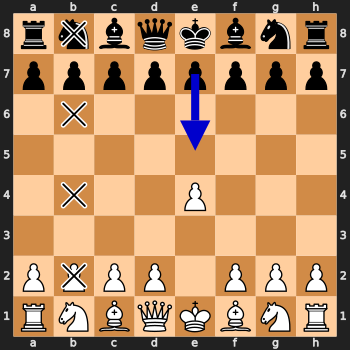



Position 1:
Fetching item 1: Position shape: torch.Size([64]), Move: 4013, SAN Move: Nf6


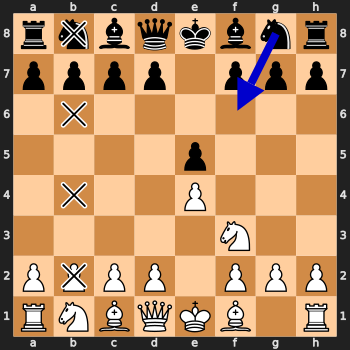



Position 2:
Fetching item 2: Position shape: torch.Size([64]), Move: 3690, SAN Move: Nc6


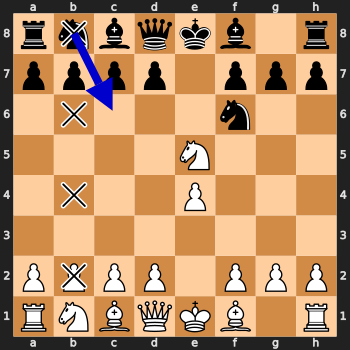



Position 3:
Fetching item 3: Position shape: torch.Size([64]), Move: 3306, SAN Move: dxc6


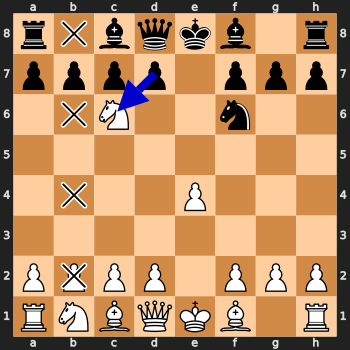

In [71]:
import chess
import chess.svg
import chess.pgn
import os
import torch
from torch.utils.data import Dataset
from IPython.display import SVG, display

MAX_MOVES = 30  # Define MAX_MOVES constant

class StaffordGambitDataset(Dataset):
    def __init__(self, games):
        self.positions = []
        self.moves = []
        self.san_moves = []
        self.svg_contents = []

        print("Initializing dataset...")

        for game_index, game in enumerate(games):
            print(f"Processing game {game_index + 1}/{len(games)}")
            board = game.board()
            mainline_moves = list(game.mainline_moves())
            for move_index, move in enumerate(mainline_moves):
                if move_index >= MAX_MOVES * 2:
                    print(f"Reached MAX_MOVES limit for game {game_index + 1}")
                    break
                if board.turn == chess.BLACK:
                    print(f"Adding position and move {move_index + 1}/{len(mainline_moves)} for game {game_index + 1}")
                    tensor = board_to_tensor(board)
                    self.positions.append(tensor)
                    move_encoded = move.from_square * 64 + move.to_square
                    self.moves.append(move_encoded)
                    san_move = board.san(move)
                    self.san_moves.append(san_move)
                    print(f"Move in SAN format: {san_move}")

                    # Generate SVG content
                    svg_content = self.generate_board_svg(board, move)
                    self.svg_contents.append(svg_content)

                board.push(move)

        print(f"Dataset initialization complete. Total positions: {len(self.positions)}")

    def generate_board_svg(self, board, move):
        svg_content = chess.svg.board(
            board,
            arrows=[chess.svg.Arrow(move.from_square, move.to_square, color="#0000cccc")],
            squares=chess.SquareSet(chess.BB_DARK_SQUARES & chess.BB_FILE_B),
            size=350,
        )
        return svg_content

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        position = self.positions[idx]
        move = self.moves[idx]
        san_move = self.san_moves[idx]
        svg_content = self.svg_contents[idx]

        if isinstance(position, torch.Tensor):
            print(f"Fetching item {idx}: Position shape: {position.shape}, Move: {move}, SAN Move: {san_move}")
        else:
            print(f"Error: Position at index {idx} is not a tensor but a {type(position)}")

        return position, move, san_move, svg_content

    def display_position(self, idx):
        _, _, _, svg_content = self[idx]
        display(SVG(svg_content))

    def display_multiple_positions(self, start_idx, num_positions):
        for idx in range(start_idx, start_idx + num_positions):
            if idx < len(self):
                print(f"Position {idx}:")
                self.display_position(idx)
                print("\n")
            else:
                break

def board_to_tensor(board):
    # Implement this function to convert a chess.Board to a tensor
    # This is a placeholder implementation
    return torch.zeros(64)  # Replace with actual tensor conversion

def main():
    games = []
    with open('stafford.txt') as pgn:  # Make sure this file contains Stafford Gambit games
        while True:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break
            games.append(game)

    dataset = StaffordGambitDataset(games)

    # Example usage:
    print("Displaying the first 5 positions:")
    dataset.display_multiple_positions(0, 5)

if __name__ == "__main__":
    main()


In [66]:
def main():
    games = []
    with open('stafford.txt') as pgn:  # Make sure this file contains Stafford Gambit games
        while True:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break
            games.append(game)

    dataset = StaffordGambitDataset(games)
    #train_size = int(0.99 * len(dataset))
    #val_size = len(dataset) - train_size
    #train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    #train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    #val_loader = DataLoader(val_dataset, batch_size=32)

    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model = StaffordGambitModel().to(device)
    #optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    #criterion = nn.CrossEntropyLoss()
    #scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    #num_epochs = 10
    #best_val_loss = float('inf')
    #for epoch in range(num_epochs):
    #    train_loss = train(model, train_loader, optimizer, criterion, device)
    #    val_loss = validate(model, val_loader, criterion, device)
    #    scheduler.step(val_loss)
    #    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    #    if val_loss < best_val_loss:
    #        best_val_loss = val_loss
    #        torch.save(model.state_dict(), 'best_stafford_gambit_model.pth')

    # Evaluate model on validation set
    #evaluate(model, val_loader, device)

if __name__ == "__main__":
    main()


Initializing dataset...
Processing game 1/1
Adding position and move 2/9 for game 1
Move in SAN format: e5
Adding position and move 4/9 for game 1
Move in SAN format: Nf6
Adding position and move 6/9 for game 1
Move in SAN format: Nc6
Adding position and move 8/9 for game 1
Move in SAN format: dxc6
Dataset initialization complete. Total positions: 4
